# Прогноз оттока клиентов фитнес-центра <a class="tocSkip">

**Цель исследования:**  
Спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента сети фитнес-центров. Сформировать типичные портреты клиентов и проанализировать основные признаки, наиболее сильно влияющие на отток. Разработать рекомендации по повышению качества работы с клиентами.

## Изучение общей информации. Проведение предобработки данных

In [2]:
# импорт библиотек
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
import warnings

In [3]:
# загрузка данных
try:
    gym = pd.read_csv('/datasets/gym_churn.csv')
except:
    gym = pd.read_csv('D:/learning/Data_Analysis/Projects/11/dataset/gym_churn.csv')

In [4]:
gym

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


- Описание данных  
  
Таблица `gym` содержит данные клиентов, журналы посещений и покупок, а также информация о текущем статусе абонемента клиента на месяц до оттока и факт оттока на определённый месяц:  

    Churn — факт оттока в текущем месяце;  
    gender — пол;
    Near_Location — проживание или работа в районе, где находится фитнес-центр;
    Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент);
    Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
    Phone — наличие контактного телефона;
    Age — возраст;
    Lifetime — время с момента первого обращения в фитнес-центр (в месяцах);
    Contract_period — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
    Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);
    Group_visits — факт посещения групповых занятий;
    Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
    Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
    Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

Мы видим, что в таблице `gym` названия столбцов записаны в разном регистре. Для удобства использования приведем данные в столбцах к нижнему регистру.

In [5]:
# переименование колонок
gym = gym.rename(columns={
    'Churn': 'churn', 
    'Near_Location': 'near_location',
    'Partner': 'partner', 
    'Promo_friends': 'promo_friends',
    'Phone': 'phone',
    'Age': 'age',
    'Lifetime': 'lifetime',
    'Contract_period': 'contract_period',
    'Month_to_end_contract': 'month_to_end_contract',
    'Group_visits': 'group_visits',
    'Avg_class_frequency_total': 'avg_class_frequency_total',
    'Avg_class_frequency_current_month': 'avg_class_frequency_current_month',
    'Avg_additional_charges_total': 'avg_additional_charges_total'
})

- Посмотрим общую информацию о таблице, также проверим данные на пропуски и дубликаты

In [6]:
# функция получения общей информации, проверки на пропуски и дубликаты
def total_info(data):
    display(data.info())
    print('Количество пропусков в столбцах:')
    display(data.isna().sum())
    print(
        'Количество дубликатов в столбцах:',
        data.duplicated().sum(), ', что составляет',
        (data.duplicated().sum() / len(data) * 100).round(1), '%'
    )

In [7]:
# получение общей информации, проверка на пропуски и дубликаты
total_info(gym)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


None

Количество пропусков в столбцах:


gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

Количество дубликатов в столбцах: 0 , что составляет 0.0 %


Всего в нашем распоряжении 4 000 наблюдений. Мы видим, что в данных отсутствуют пропуски и дубликаты, однако столбец `month_to_end_contract` имеет вещественный тип данных. Так это срок до окончания текущего действующего абонемента в месяцах, то преобразуем его в целочисленный тип данных.          

In [8]:
# изменение типа данных
gym['month_to_end_contract'] = gym['month_to_end_contract'].astype('int64')

In [9]:
# проверка
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null int64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(3), int64(11)
memory usage: 437.6 KB


### Вывод

Мы заменили названия столбцов таблицы, проверили данные на наличие пропусков и дубликатов, привели данные к нужному типу. Теперь они готовы к дальнейшему анализу.

## Исследовательский анализ данных (EDA)

В нашем датасете 4 000 наблюдений, целевая переменная `churn` и 13 различных признаков. В датасете все категориальные признаки уже преобразованы в числовые значения. Целевая переменная не имеет временной структуры. 

- **Изучим средние значения и стандартные отклонения признаков.**   
Для этого применим метод `describe()`.

In [10]:
gym.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


В целом мы наблюдаем, что:
- большинство клиентов фитнес-центра работают или проживают рядом с фитнес-центром;
- от 25% до 50% клиентов воспользовались акцией "приведи друга" или являются сотрудниками компании-партнера;
- половина клиентов покупают абонемент на срок 1 месяц, Средние значения 4,68 месяцев, то есть период 3 или 6 месяцев;
- от 25% до 50% клиентов посещают групповые занятия;
- средний возраст клиентов 29 лет, максимальный 41. Стандартное отклонение 3 года, данные не слишком сильно варьируются;
- средняя выручка от других услуг фитнес-центра 147 усл. ед. При этом 75% клиентов тратят на дополнительные услуги не более 211 усл. ед. в месяц, максимум 552 усл. ед. Стандартное отклонение 96 усл. ед., можно сказать что выручка от клиента к клиенту довольно сильно различается;
- среднее время с момента первого обращения в фитнес-центр у данных клиентов чуть более 3 месяцев;
- в среднем клиенты посещают фитнес-центр около 2 раз в неделю.

- **Теперь сравним средние значения признаков в двух группах клиентов — тех, кто ушел в отток и тех, кто остался.**

In [11]:
gym.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


In [12]:
gym.groupby('churn').count()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939
1,1061,1061,1061,1061,1061,1061,1061,1061,1061,1061,1061,1061,1061


В группах можно наблюдать явные различия:
- клиенты, которые не ушли в отток приобретали абонементы в среднем на 6 месяцев, а те, кто ушли в среднем на 1-3 месяца;
- среди тех, кто не ушел больше клиентов, воспользовавшихся акцией "приведи друга", являющихся сотрудниками компании-партнера,  проживающих или работающих поблизости от фитнес-центра, а также посещающих групповые занятия;
- средний возраст клиентов ушедших в отток 26 лет, что на 3 года меньше среднего возраста не ушедших клиентов. Можно предположить, что молодые люди больше любят экспериментировать, пробовать новое. Они могут чаще менять фитнес-центры или свои увлечения;
- также те, кто не ушел в отток гораздо охотнее пользуются дополнительными услугами фитнес-центра (средняя выручка на 43 усл. ед. выше);
- клиенты, которые уходят в отток в среднем делают это через 1 месяц после первого посещения фитнес-центра;
- можно заметить, что посещают они фитнес-центр также реже - в среднем 1 - 2 раз в неделю, особенно снижается количество посещений в месяце перед оттоком - 1 посещение в неделю.

- **Построим столбчатые гистограммы и распределения признаков для тех клиентов, кто ушёл (отток) и тех, кто остался (не попали в отток).**

In [13]:
# функция построения графиков по признакам

def feature_charts(data):
    sns.set(style="whitegrid")
    
    # задание расположения графиков
    fig, axs = plt.subplots(4, 2, figsize=(15, 30))
    axs = axs.ravel()
    
    # цикл для построения столбчатых диаграмм (убираем столбцы, для котрых будет использован другой вид графика)
    i = 0    
    for col in data.drop(
                   ['churn',
                    'age', 
                    'avg_additional_charges_total',
                    'month_to_end_contract', 
                    'lifetime',
                    'avg_class_frequency_total',
                    'avg_class_frequency_current_month'],
                    axis = 1
                ).columns:
        
        # группировка данных
        data_group = data.groupby(
                              ['churn', col], as_index=False
                          )['age'].count().rename(
                                               columns={'age': 'Количество', 'churn': 'Факт оттока клиента'}
                                           )
        # пострение графика
        sns.barplot(x="Факт оттока клиента", y="Количество", hue=col, data=data_group, ci=None, ax=axs[i])
        axs[i].set(title='Распределение признака '+col)
        fig.show()
        
        i+=1
    
    # удаление лишнего места под график
    axs[7].remove() 
    
    # задание расположения графиков
    fig, axs = plt.subplots(3, 2, figsize=(15, 22))
    axs = axs.ravel()
    
    # цикл для построения гистограмм (убираем столбцы, для котрых был использован другой вид графика)
    i = 0
    for col in data.drop(
               ['churn',
                'gender',
                'near_location',
                'partner', 
                'promo_friends',
                'phone',
                'contract_period',
                'group_visits'],
                axis = 1
            ).columns:  
        
        # пострение графика для неушедших клиентов
        sns.histplot(data=data.query('churn == 0'),
                     x=col,
                     kde=False,
                     color="tomato", 
                     label="клиенты оставшиеся", 
                     ax=axs[i])
        
        # пострение графика для оттока
        sns.histplot(data=data.query('churn == 1'),
                     x=col,
                     kde=False,
                     color="steelblue",
                     label="клиенты, попавшие в отток", 
                     ax=axs[i]) 
        
        axs[i].set(title='Распределение признака '+col)
        axs[i].set(ylabel='Количество')
        axs[i].legend()
        fig.show()
        
        i+=1        

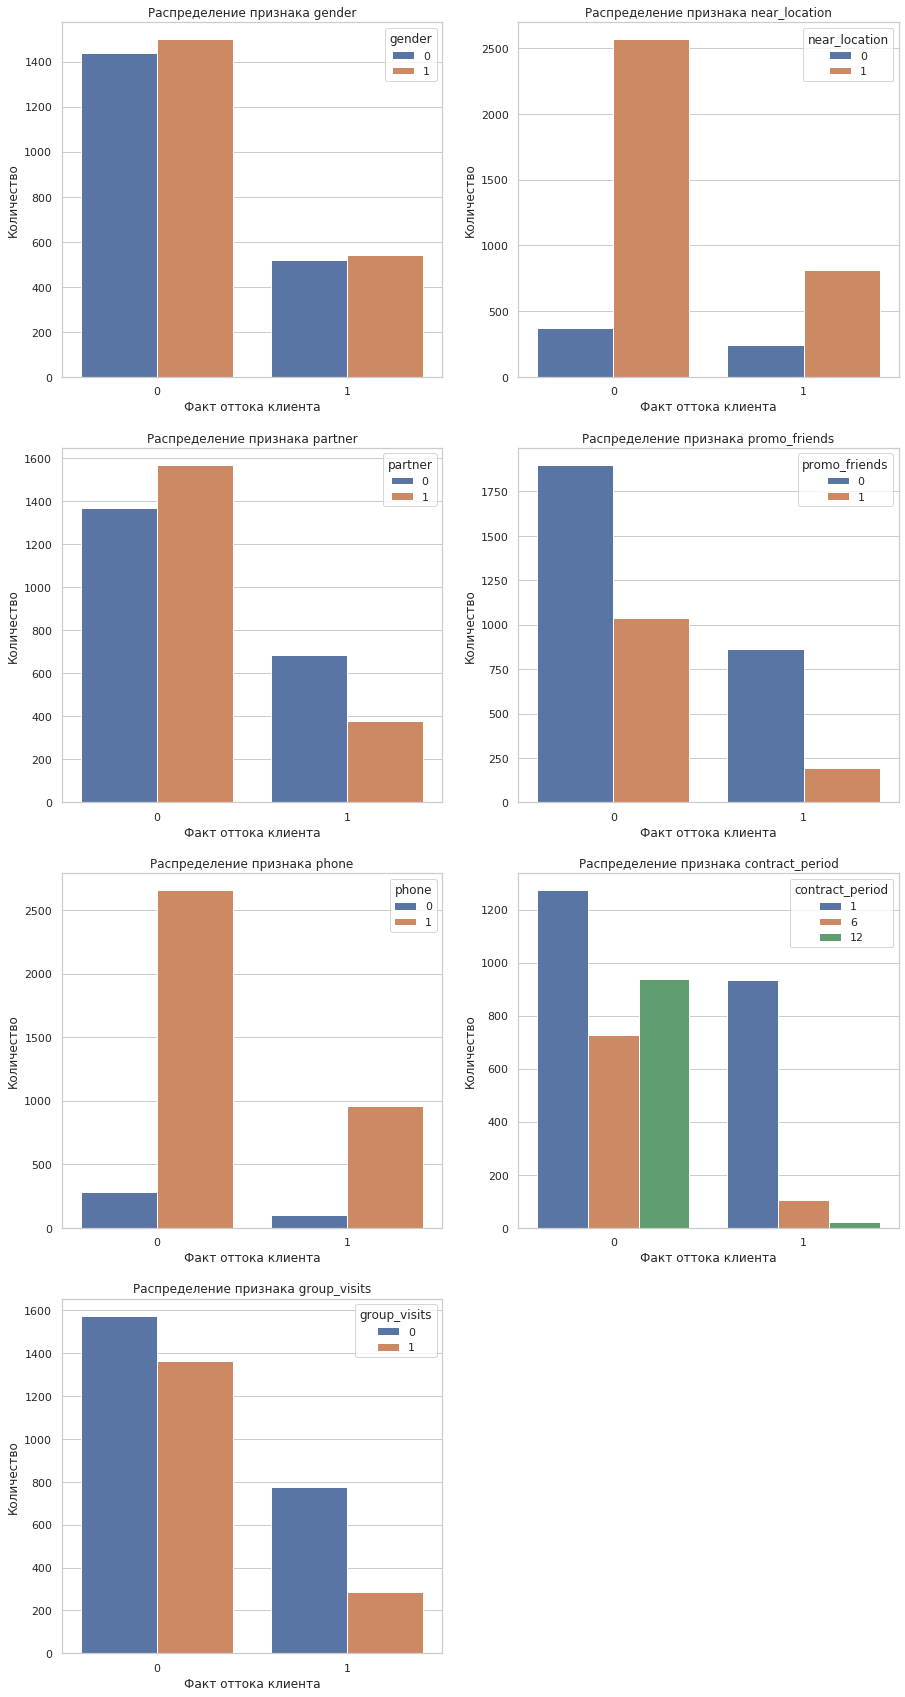

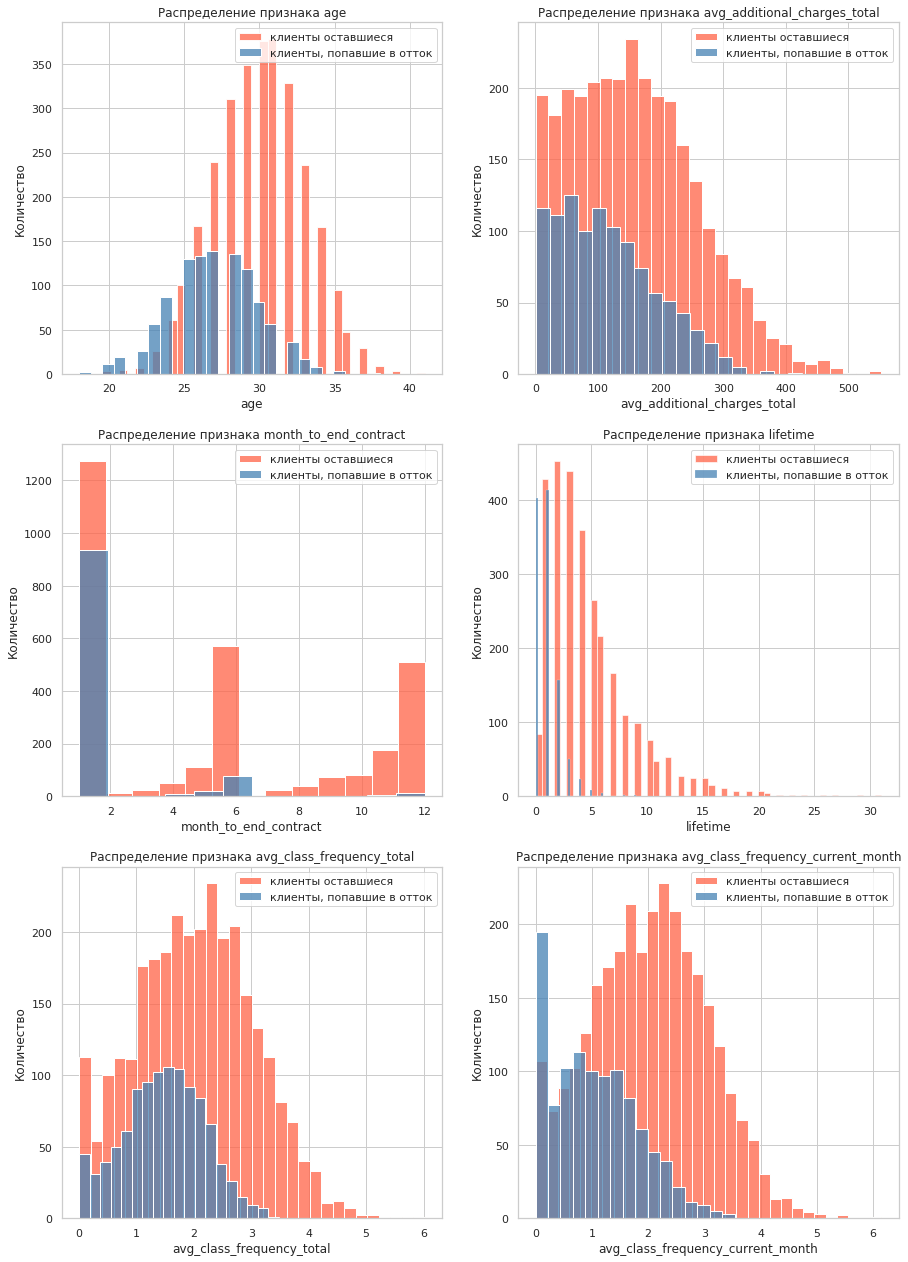

In [14]:
feature_charts(gym)

Изучив графики, можно сказать, что:
- похоже, что клиенты проживающие или работающие рядом с фитнес-центром, чаще остаются, а количество клиентов, не проживающих и неработающих в районе фитнес-центра, среди тех кто остался и ушел практически одинаковое. Тоже самое можно сказать про клиентов, пожелавших оставить свой контактный телефон, они более лояльны;
- среди не ушедших клиентов гораздо больше тех, кто является сотрудником компании-партнера, в то время как у клиентов попавших в отток совсем наоборот;
- среди клиентов, которые покупают абонементы на 6 или 12 месяцев, мало тех, кто уходит;
- гистограмма возраста клиентов имеет нормальное распределение, при этом клиенты попавшие в отток моложе, в среднем 23 - 30 лет;
- среди ушедших клиентов в основном те кто, посещал фитнес-центр не более 2-3 месяцев;
- частота посещения клиентами фитнес-центра в целом за период и предшествующем месяце различается. Клиенты, попавшие в отток, в предшествующем месяце либо переставали посещать фитнес-центр, либо делали это 1 раз в неделю, изредка 2 раза в неделю.

- **Построим матрицу корреляций и отобразим её.**

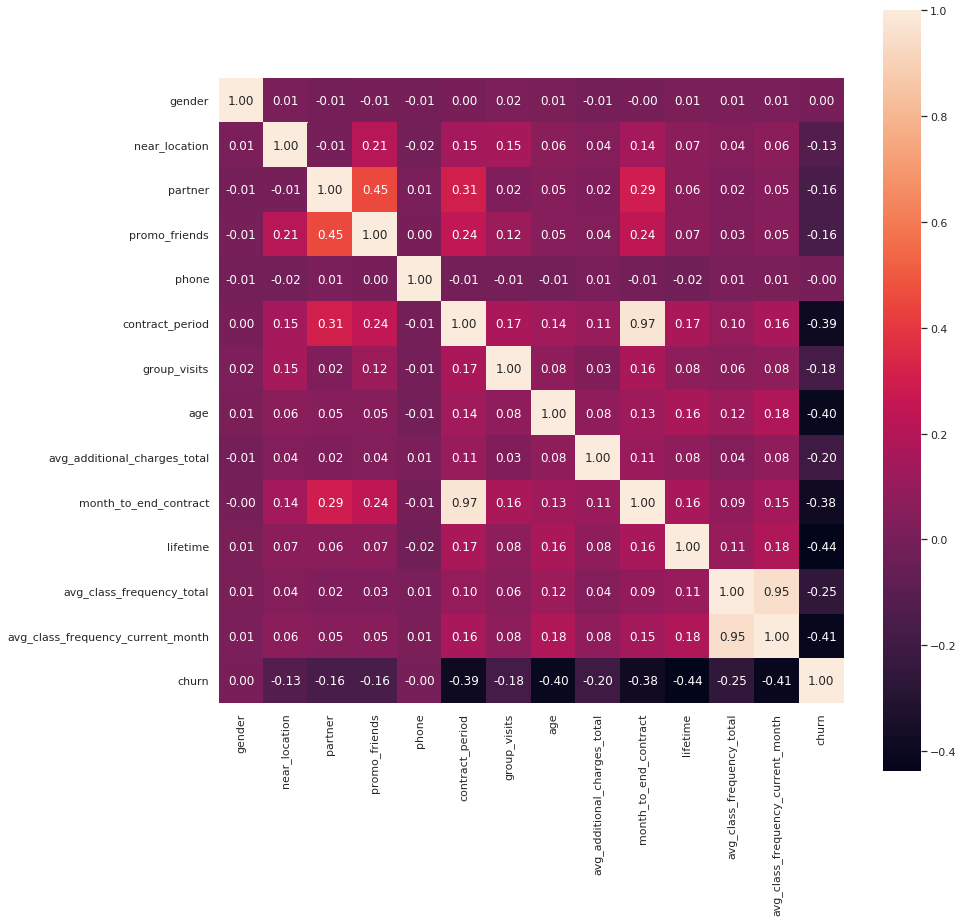

In [15]:
# вычисляем матрицу корреляций
cm = gym.corr() 

# тепловая карта 
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(cm, annot=True, square=True, fmt=".2f")
plt.show()

С целевой переменной признаки сильно не коррелируют. Однако у нас появилось **две пары сильно скоррелированных признаков:** 
1. период, на который приобретен абонемент и количество месяцев до окончания абонемента;
2. среднее количество посещений в неделю в прошедшем месяце и в целом за период.  
 
    
**На целевую переменную чуть больше влияют признаки:** 
1. время с первого посещения (в месяцах); 
2. возраст;
3. среднее количество посещений в неделю за предыдущий месяц;
4. срок, на который приобретен абонемент.
  
При этом мы наблюдаем обратную зависимость, то есть, чем выше показатель признаков, тем больше вероятность, что клиент не уйдет.

### Вывод

Изучив признаки и целевую переменную можно сказать следующее:
1. У нас нет каких-либо сильно аномальных значений или выбросов.
2. На целевую переменную сильнее оказывают влияние 4 признака: время с первого посещения (в месяцах), возраст, среднее количество посещений в неделю за предыдущий месяц и срок, на который приобретен абонемент.
3. Исходя из задач, мы будем применять модель бинарной классификации, с целевой переменной - факт оттока клиента и кластеризацию пользователей.
4. У нас есть две пары сильно скоррелированных признаков, мы пременим регуляризацию, встроенную в алгоритм логистической регрессии.
5. В данных нет временной структуры, поэтому разбиение на валидационную и тестовую выборки можно сделать случайным методом.
6. В качестве алгоритмов бинарной классификации будем использовать: логистическую регрессию и случайный лес. В качестве алгоритма кластеризации - K-Means.
7. Так как нам нужно предсказать факт оттока клиентов будем оценивать метрики Accuracy, Precision и Recall. 

## Построение модели прогнозирования оттока клиентов

Построим модели, которые помогут спрогнозировать отток клиентов.

- **Разобьем данные на обучающую и валидационную выборку.**

In [16]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = gym.drop('churn', axis = 1)
y = gym['churn']

In [17]:
# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

- **Обучим модель на train-выборке двумя алгоритмами:**  
логистической регрессией,  
случайным лесом.

In [18]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = gym.drop('churn', axis=1)
y = gym['churn']

# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0, solver='liblinear')

# обучим модель
lr_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

# зададим алгоритм для модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(random_state = 0, n_estimators=100)  
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)  
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

- **Оценим метрики для обеих моделей на валидационной выборке и сравним по ним модели.**

In [19]:
# определим функцию, которая будет выводить метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))   
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [20]:
# посмотрим на баланс классов набора данных
print('Соотношение классов:\n', (gym['churn'].value_counts() / len(gym) * 100), '\n')

# выведем метрики логистической регрессии
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

# выведем метрики случайного леса
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities, 
    title='Метрики для модели случайного леса:'
)

Соотношение классов:
 0    73.475
1    26.525
Name: churn, dtype: float64 

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
	ROC_AUC: 0.97
Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81
	ROC_AUC: 0.97


**Метрики модели на основе алгоритма логистической регрессии выглядят немного лучше**: в частности, метрики `Precision` и `Recall`. Точность и полнота предсказаний модели логистической регрессии на уровне 85% и 83%, что выглядит довольно хорошо.  
  
Метрика `Accuracy` показывает нам, что обе модель правильно прогнозируют 92% ответов, однако эта метрика в данном случае может и не сработать, так как у нас есть различия в классах: 73% на 27%.  

Дополнительно мы рассмотрели метрику `ROC_AUC`, которая показала нам, что качество обоих классификаторов составляет 97%. Это очень хороший показатель. 

### Вывод

Мы обучили 2 модели алгоритмами логистической регрессии и случайного леса. На основании изученных метрик можно сказать, что **модель на основе алгоритма логистической регрессии показывает себя лучше**.

## Кластеризация клиентов

Сформируем типичные портреты клиентов: выделим 5 наиболее ярких групп и охарактеризуем их основные свойства.

- **Стандартизируем данные.**

In [21]:
# стандартизируем данные (используем матрицу признаков, то есть данные без целевой переменной)
sc = StandardScaler()
X_sc = sc.fit_transform(X)

- **Построим матрицу расстояний на стандартизованной матрице признаков и нарисуем дендрограмму.**

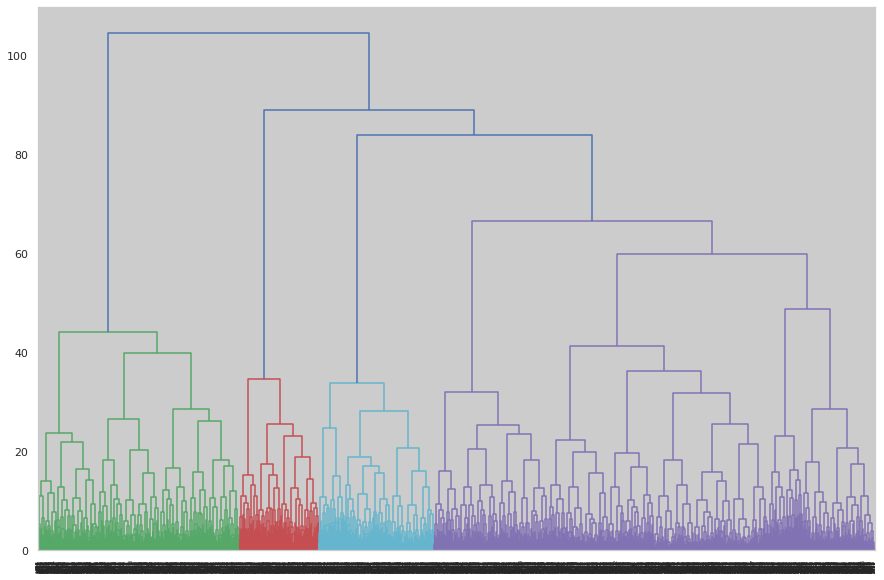

In [22]:
# матрица расстояний
linked = linkage(X_sc, method = 'ward')

# построение дендрограммы
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

На данной дендрограмме предложено оптимальное число число кластеров 4. 

- **Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.**   

Возьмем число кластеров n = 5.

In [23]:
# зададим модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state=0)

# спрогнозируем кластеры для наблюдений 
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле датасета
gym['cluster_km'] = labels

- **Изучим средние значения признаков для кластеров.**

In [24]:
# выводим статистику по средним значениям признаков по кластеру
gym.drop('churn', axis = 1).groupby('cluster_km', as_index=False).mean()

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225
1,1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369
2,2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324
3,3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983
4,4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473


Можно заметить, что по средним значениям:
- признаки пол и возраст примерно одинаково распределены по всем кластерам;  
 
 
- по признаку период абонемента сильно отличаются от других 0 и 1 кластеры, очевидно туда попали клиенты, в основном купившие абонементы на продолжительный срок 12 и 6 месяцев;  
  
  
- по суммарной выручке за дополнительные услуги выделяются 0 и 4 кластеры, средняя выручка в этих группах выше. Также клиенты этих групп имеют самый высокий lifetime (время с первого посещения фитнес-центра) и у них выше средние показатели посещаемости в неделю. Вероятно они довольно активны и давно являются клиентами фитнес-центра, а также охотно пользуются дополнительными услугами;  
  
  
- клиенты в 2 и 3 кластере имеют наиболее низкие показатели: приобретают абонементы на более короткие периоды, неохотно посещают групповые программы или пользуются доп. услугами фитнес-центра, реже посещают фитнес-центр. Как правило это клиенты не являются сотрудниками компании-партнера, не пользовались акцией "приведи-друга" и являются чуть моложе клиентов остальных кластеров. В целом можно сказать, что они менее заинтересованы и нуждаются в дополнительной мотивации, повышении заинтересованности.

- **Построим распределения признаков для кластеров.**

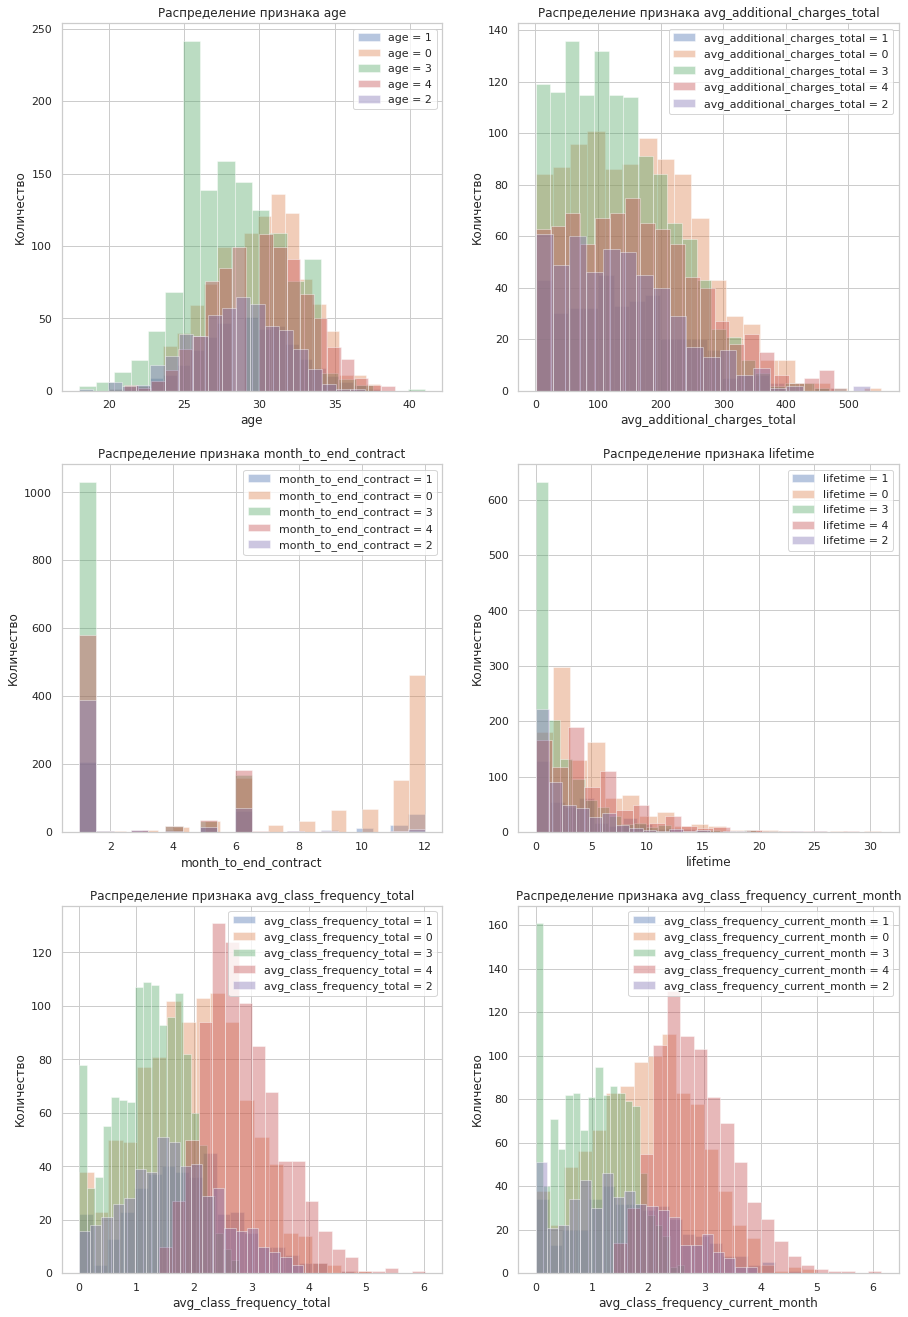

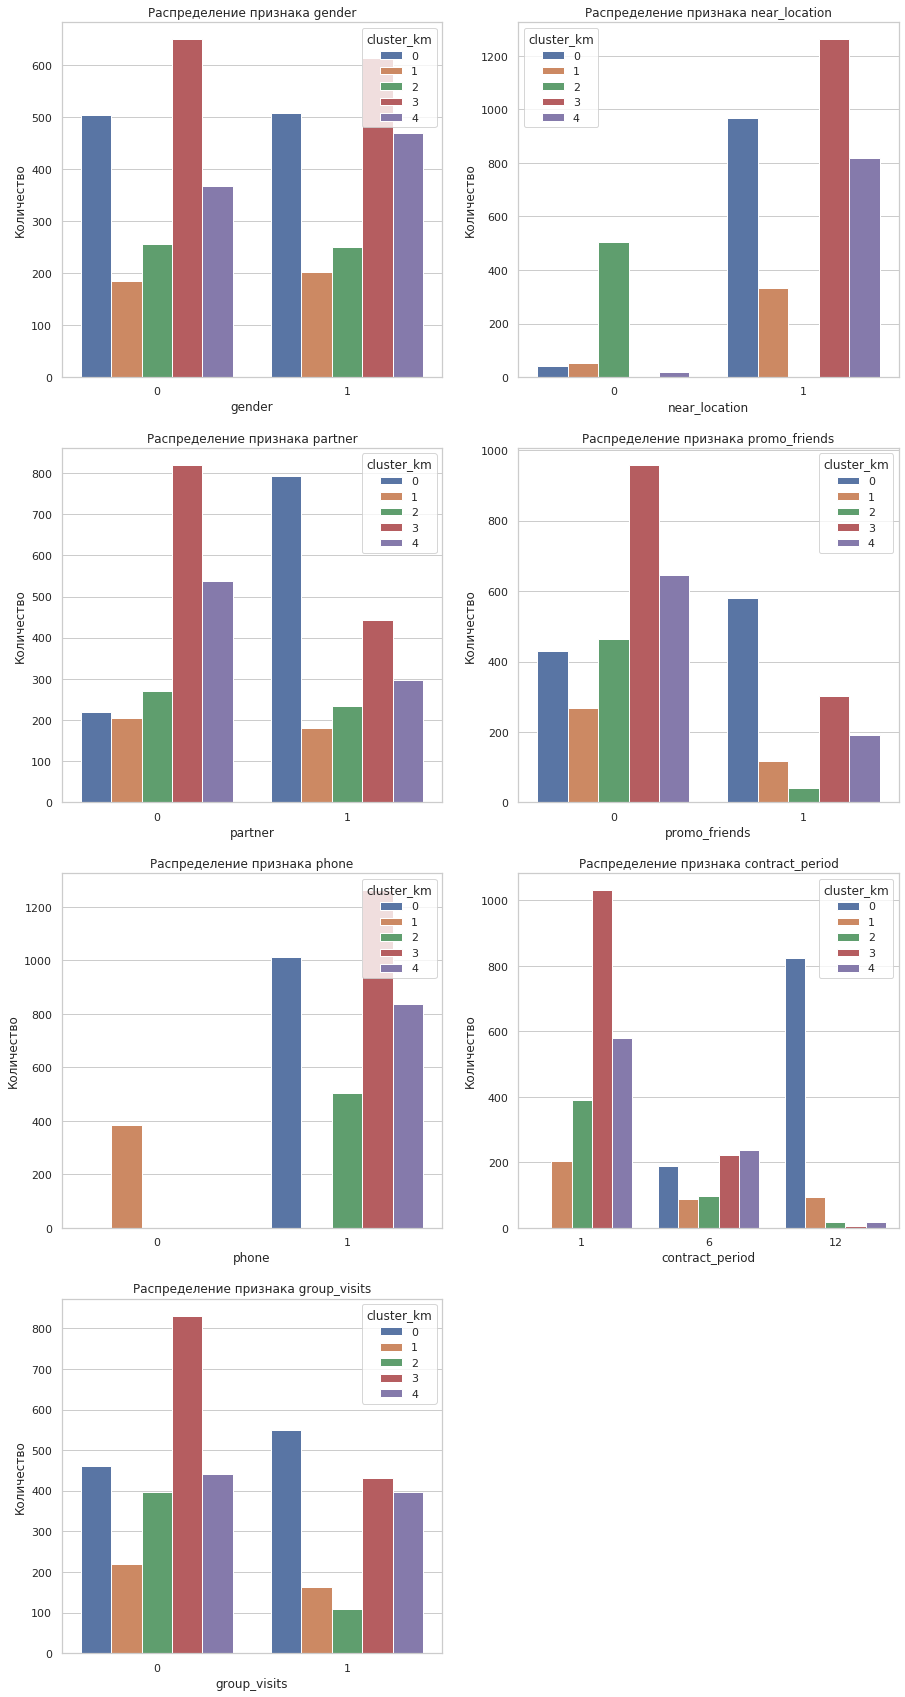

In [25]:
# игнорирование предуреждения о distplot
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set(style="whitegrid")

# задание расположения графиков
fig, axs = plt.subplots(3, 2, figsize=(15, 23))
axs = axs.ravel()

# цикл для построения гистограмм (удаляем признаки, для которых используется другой вид графика)
j = 0
for feature in gym.drop(
    ['churn',
     'cluster_km', 
     'gender',
     'near_location',
     'partner',
     'promo_friends',
     'phone',
     'contract_period',
     'group_visits'],     
     axis = 1).columns:
    
    for cluster in gym.cluster_km.unique():
        sns.distplot(gym[gym['cluster_km']== cluster][feature], 
                         label='{} = {}'.format(feature, str(cluster)), bins = 20, kde = False, ax=axs[j])
    
    axs[j].set(title='Распределение признака '+ feature)
    axs[j].set(ylabel='Количество')
    axs[j].legend()
    fig.show()
    
    j += 1
    
# задание расположения графиков
fig, axs = plt.subplots(4, 2, figsize=(15, 30))
axs = axs.ravel()
    
# цикл для построения столбчатых диаграмм (убираем столбцы, для котрых использован другой вид графика)
i = 0    
for feature in gym.drop(
    ['churn',
     'cluster_km',
     'age', 
     'avg_additional_charges_total',
     'month_to_end_contract',
     'lifetime',
     'avg_class_frequency_total',
     'avg_class_frequency_current_month'],
    axis = 1).columns:
        
    # группировка данных
    gym_group = gym.groupby(
        [feature, 'cluster_km'], as_index=False
    )['age'].count().rename(
        columns={'age': 'Количество'}
                                           )
    # пострение графика
    sns.barplot(x=feature, y="Количество", hue='cluster_km', data=gym_group, ci=None, ax=axs[i])
    axs[i].set(title='Распределение признака '+feature)
    fig.show()
        
    i+=1
    
# удаление лишнего места под график
axs[7].remove()

По графикам видно, что:
- во 3 кластере больше всего клиентов имеющий самый низкий lifetime (0 месяцев);  
  
  
- клиенты 4 кластера чаще других посещают тренажерный зал, а вот клиенты 3 кластера - наоборот реже, среди них больше тех, кто вообще в текущем месяце не посещал занятия;  
  
  
- к клиентам, не проживающим и не работающим рядом с фитнес-центром модель в основном отнесла клиентов 2 кластера;  
  
  
- все клиенты, кроме клиентов 1-го кластера предоставили свой контактный телефон. Клиенты этого кластера занимают среднюю позицию, их нельзя назвать нелояльными, поэтому можно сказать, что факт предоставления или не предоставления телефона здесь, не играет особой роли.

- **Для каждого полученного кластера посчитаем долю оттока. Выясним какие кластеры склонны к оттоку, а какие — надёжны.**

In [26]:
(
    (gym.groupby('cluster_km')['churn'].sum() / gym.groupby('cluster_km')['churn'].count() * 100)
    .round(1)
    .to_frame()
    .reset_index()
    .rename(columns={'cluster_km': 'Кластер', 'churn': 'Доля оттока (%)'})
)

,Кластер,Доля оттока (%)
0,0,2.8
1,1,26.8
2,2,44.4
3,3,51.4
4,4,6.8


Как и ожидалось **клиенты в 2 и 3 кластерах наиболее склонны к оттоку**, клиенты в 1 кластере занимают среднюю позицию, а **клиенты в 0 и 4 кластерах - самые надежные**.

### Вывод

Мы разделили пользователей на 5 групп и кластеризация помогла нам выделить 2 пары наиболее ярких и схожих групп. Это позволило охарактеризовать **типичные портреты надежных клиентов и склонных к оттоку:**  
  
  
1. **Надежные клиенты** склонны покупать абонементы на более продолжительный срок 12 и 6 месяцев, они более охотно пользуются дополнительными услугами фитнес-центра и приносят больше выручки, у них выше средние показатели посещаемости в неделю. Большинство из них, уже не первый месяц являются клиентами фитнес-центра. Как правило они работают или проживают в районе фитнес-центра и часто являются сотрудниками компании-партнера клуба. Такие клиенты уходят лишь в 3-7% случаев.  
  
  
2. **Клиенты, склонные к оттоку** часто приобретают абонементы на более короткие периоды, в основном на 1 месяц, реже посещают групповые программы и меньше пользуются дополнительными услугами фитнес-центра. Они реже посещают фитнес-центр, в месяце перед оттоком они часто вообще перестают посещать зал. Как правило это клиенты не являющиеся сотрудниками компании-партнера, и они не пользовались акцией "приведи-друга". Среди таких клиентов часто попадаются те, кто не проживает и не работает рядом с фитнес-центром. Этот сегмент клиентов часто моложе других примерно 23-34 года. Часто они уходят в течение 1-2 месяцев после первого посещения. Доля оттока таких клиентов высока - 44-51%.

## Выводы и базовые рекомендации по работе с клиентами

**Общие выводы:**  
  
1. Мы провели исследовательский анализ данных и выяснили, что **на факт оттока сильнее оказывают влияние 4 признака: время с первого посещения (в месяцах), возраст, среднее количество посещений в неделю за предыдущий месяц и срок, на который приобретен абонемент**. Чем ниже эти показатели, тем вероятнее факт оттока клиента. Менее всего оказывают влияние факты предоставления или не предоставления телефона или пол.   
  
  
2. Мы обучили две модели, которые прогнозируют отток клиентов: на основе алгоритмов логистической регресии и случайного леса. Сравнив метрики этих моделей на тестовых выборках, мы пришли к выводу, что **модель на основе алгоритма логистической регрессии показывает себя лучше**. В частности, метрики точности и полноты прогноза немного выше - на 1-2%.  
  
  
3. Для того, чтобы сформировать **типичные портреты пользователей**, мы провели кластеризацию и выделили 4 группы пользователей (с 0 по 3). 
  
В целом **надежных клиентов можно охарактеризовать, как**:
- склонных покупать абонементы на продолжительный срок (12-6 месяцев);
- охотно пользующихся дополнительными услугами фитнес-центра (средняя выручка 162 усл. ед.);
- посещающих фитнес-центр в среднем 2 - 3 раза в неделю;
- зачастую являющихся сотрудниками компаний-партнеров клуба и проживающих или работающих рядом с фитнес-центром;
-  и как правило они уже не первый месяц являются клиентами фитнес-центра.   
  
  
**Клиенты, склонные к оттоку часто уходят в течение 1-2 месяцев после первого посещения. Их можно охарактеризовать, как**:
- приобретающих абонементы на более короткие периоды, в основном на 1 месяц;
- посещающих занятия в среднем 1-2 раза в неделю, а в месяце перед оттоком и зачастую вовсе перестающих посящать фитнес-центр;
- эти клиенты реже интересуются групповыми программами и меньше пользуются дополнительными услугами фитнес-центра (средняя выручка 130-135 усл. ед.);
- среди них часто попадаются те, кто не проживает и не работает рядом с фитнес-центром и соответственно не являются сотрудниками компании-партнера клуба;
- и они редко пользуются акцией "приведи-друга";
- этот сегмент клиентов часто моложе других примерно 23-34 года. 

**Рекомендации по работе с клиентами** 
  
  
Чтобы снизить отток клиентов рекомендуется принять следующие меры:
1. На основе обученной модели ежемесячно прогнозировать отток конкретных клиентов.
2. К клиентам, попавшим в группу риска, стоит применить индивидуальный подход. Например: посредством email, sms или мессенджеров напомнить клиенту о заканчивающемся абонементе и предложить продление со скидкой на абонемент или дополнительные услуги фитнес-центра. Таким образом можно мотивировать клиента и дополнительно продать ему услуги фитнес-центра. 
3. Так как у нас есть категории клиентов, которые перестают посещать фитнес-центр в первый или во второй месяц после знакомства с фитнес-центром, то к клиентам, впервые посещающим фитнес-центр нужен новый подход. Необходимо повысить их заинтересованность в данном фитнес-центре. Возможной стратегией будет так называемая интеграция и адаптация новичков. Кроме вводной консультации можно предложить начать с групповых тренировок или провести бесплатную персональную тренировку с тренером, который расскажет все про каждый тренажер, составит план тренировки.
4. Разделить подход к клиентам, посещающим групповые тренировки и тренажерный зал. Заранее уведомлять клиентов о планирующихся в следующем месяце/квартале марафонах (актуально для любителей групповых программ) или семинарах с приглашенными экспертами по подбору спортивного питания и наращиванию мышечной массы (актуально для любителей тренажерного зала). И сделать посещение таких мероприятий бесплатным для членов клуба (то есть имеющих действующий абонемент). 